# Interaction Data Analyses


In [1]:
import re
import json
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import util_func as uf
from textwrap import wrap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerTuple

sns.set_style("whitegrid")
np.random.seed(42)
palette = ["#84c3b7", "#7da6c6", "#eaaa60", "#e56b6f", "#c5c5c5"]

dicts = json.load(open("../data/dictionary.json"))

df = pd.read_csv("../data/experiment_anonymized.csv")

tasks, agents = dicts["tasks"], dicts["agents"]

strategy_dict, null_strat_dict = dicts["strategy"], dicts["null_strategy"]

demo_vars, personality_vars, social_vars = (
    dicts["demo_vars"],
    dicts["personality_vars"],
    dicts["social_vars"],
)

continuous_vars, category_dict = dicts["continuous_vars"], dicts["category_dict"]

other_cats = dicts["other_cats"]
for aspect in ["work", "marital_status", "education", "ethnicity"]:
    df[aspect] = df[aspect].apply(
        lambda x: (
            x.lower().replace("-", "_")
            if x.lower() in other_cats[aspect]
            else "other" if aspect != "marital_status" else "single"
        )
    )

df["task_group"] = pd.Categorical(df["task_group"], tasks)
df["agent_group"] = pd.Categorical(df["agent_group"], agents)
df.sort_values(["task_group", "agent_group"], inplace=True)
df["data_source"] = np.where(df["lang"].str.contains("zh"), "wechat", "prolific")
df["identifier"] = df["user_code"].apply(lambda x: x.replace("P_", ""))

# Ratings for the hidden incentive
df["hidden_pre"] = df.apply(lambda x: uf.get_goal_score(x, "pre"), axis=1)
df["hidden_post"] = df.apply(lambda x: uf.get_goal_score(x, "post"), axis=1)

# Delta for ratings in optimal options and hidden incentives
df["hod_pre"] = df["hidden_pre"] - df["a_pre"]
df["hod_post"] = df["hidden_post"] - df["a_post"]

# Preference category based on ratings
df["pref_pre"] = df.apply(lambda x: uf.get_preference(x, "pre"), axis=1)
df["pref_post"] = df.apply(lambda x: uf.get_preference(x, "post"), axis=1)

print(f"{len(df)//3} Participants - {len(df)} Samples")

233 Participants - 699 Samples


## HOD (Hidden-Optimal Differential)


### Between AI conditions


In [2]:
for source in ["all", "prolific", "wechat"]:
    for task in tasks:
        print(f"### {task} - {source} ###")
        uf.print_mixed_anova_res(
            df[
                (df["task_group"] == task)
                & (df["data_source"] == source if source != "all" else True)
            ],
            choice_type="hod",
            group_type="agent_group",
            dv="Rating",
            # latex_ver=True
        )
    print()

### Financial - all ###
Mixed ANOVA for HOD => F = 25.19 , dof = 2, 113, p = 2.69\times 10^{-9}, np2 = 0.31
T-tests -> 6 comparisons, confidence = 99.17%
    Time    A        B       mean(A)    mean(B)    std(A)    std(B)  CI                dof      T  p_text                cohen  Effect_CI
--  ------  -------  ----  ---------  ---------  --------  --------  --------------  -----  -----  ------------------  -------  --------------
 0  post    Neutral  MA        -1.48       1.23      1.76      3.08  [-3.57, -1.83]  58.14  -4.73  8.93\times 10^{-5}    -1.09  [-1.45, -0.72]
 1  post    Neutral  SEMA      -1.48       2.40      1.76      3.15  [-4.76, -2.99]  57.37  -6.67  6.55\times 10^{-8}    -1.53  [-1.92, -1.14]
 2  post    MA       SEMA       1.23       2.40      3.08      3.15  [-2.26, -0.09]  74.00  -1.65  0.63                  -0.38  [-0.73, -0.02]
 3  pre     Neutral  MA        -0.69      -0.87      1.62      2.17  [-0.49, 0.84]   68.24   0.41  1.00                   0.09  [-0.25, 

### Between Domains


In [3]:
for source in ["all", "prolific", "wechat"]:
    for agent in agents:
        print(f"### {agent} - {source} ###")
        uf.print_mixed_anova_res(
            df[
                (df["agent_group"] == agent)
                & (df["data_source"] == source if source != "all" else True)
            ],
            choice_type="hod",
            group_type="task_group",
            dv="Rating",
            # latex_ver = True
        )
    print()

### Neutral - all ###
Mixed ANOVA for HOD => F = 1.70 , dof = 1, 77, p = 0.20, np2 = 0.02
T-tests -> 2 comparisons, confidence = 97.50%
    Time    A          B            mean(A)    mean(B)    std(A)    std(B)  CI               dof     T    p_text    cohen  Effect_CI
--  ------  ---------  ---------  ---------  ---------  --------  --------  -------------  -----  ----  --------  -------  -------------
 0  post    Financial  Emotional      -1.48      -2.43      1.76      1.66  [0.45, 1.45]   76.92  2.48      0.03     0.56  [0.26, 0.85]
 1  pre     Financial  Emotional      -0.69      -1.11      1.62      1.65  [-0.06, 0.90]  76.83  1.14      0.52     0.26  [-0.04, 0.55]
### MA - all ###
Mixed ANOVA for HOD => F = 0.68 , dof = 1, 73, p = 0.41, np2 = 0.01
T-tests -> 2 comparisons, confidence = 97.50%
    Time    A          B            mean(A)    mean(B)    std(A)    std(B)  CI               dof     T    p_text    cohen  Effect_CI
--  ------  ---------  ---------  ---------  ---------  -

### Figure


/var/folders/_m/blpl95d53ns5nqzldymg2s940000gn/T/ipykernel_78932/2968917178.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(
/var/folders/_m/blpl95d53ns5nqzldymg2s940000gn/T/ipykernel_78932/2968917178.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(
/var/folders/_m/blpl95d53ns5nqzldymg2s940000gn/T/ipykernel_78932/2968917178.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(
/var/folders/_m/blpl95d53ns5nqzldymg2s940000gn/T/ipykernel_78932/2968917178.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(
/var/folders/_m/blpl95d53ns5nqzldymg2s940000gn/T/ipy

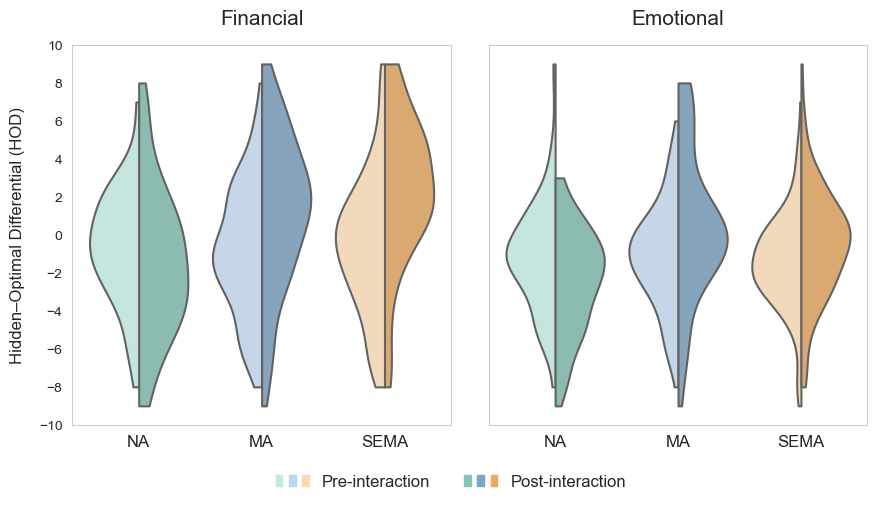

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(9, 5.2), sharey="row")
agent_palettes = {
    "Neutral": ["#C0EAE2", "#84c3b7"],  # Green
    "MA": ["#BED6ED", "#7da6c6"],  # Blue
    "SEMA": ["#FCD9B3", "#eaaa60"],  # Orange
    "Random": ["#F1A8AA", "#e56b6f"],  # Red
}
handles = []
labels = ["Pre-interaction", "Post-interaction"]
for i, task in enumerate(tasks):
    task_df = df[df["task_group"] == task]
    plot_data = task_df.melt(
        id_vars=["agent_group"],
        value_vars=["hod_pre", "hod_post"],
        var_name="time",
        value_name="rating",
    )
    plot_data["time"] = plot_data["time"].map(
        {"hod_pre": "Pre-interaction", "hod_post": "Post-interaction"}
    )

    for agent in agents:
        agent_data = plot_data[plot_data["agent_group"] == agent]
        sns.violinplot(
            data=agent_data,
            x="agent_group",
            y="rating",
            hue="time",
            split=True,
            inner=None,
            palette=agent_palettes[agent],
            ax=axs[i],
            cut=0,
            linewidth=1.5,
        )

        axs[i].set_ylabel("")
        axs[i].set_xlabel("")
        # axs[i][j].set_ylim(1, 10.05)
        axs[i].grid(axis="x", which="both", visible=False)
        axs[i].grid(axis="y", which="both", visible=False)
        axs[i].legend([], [], frameon=False)
        axs[i].margins(0.05)
        axs[i].set_xticklabels(
            [agent.replace("Neutral", "NA") for agent in agents], fontsize=12
        )
        axs[i].set_yticks(np.arange(-10, 11, 2))

        axs[i].set_title(
            task,
            pad=15,
            fontsize=15,
        )
        axs[0].set_ylabel("Hidden–Optimal Differential (HOD)", fontsize=12, labelpad=10)
        # axs[i][0].set_ylim(-0.2, 10.2)


for i, time in enumerate(["pre", "post"]):
    swatches = tuple(mpatches.Patch(color=agent_palettes[agent][i]) for agent in agents)
    handles.append(swatches)
    labels.append(time)

axs[0].legend(
    handles=handles,
    labels=labels,
    handler_map={tuple: HandlerTuple(ndivide=None)},
    loc="center",
    ncols=2,
    fontsize=12,
    bbox_to_anchor=(1.00, -0.15),
    frameon=False,
)

fig.tight_layout()
plt.subplots_adjust(left=0.1, wspace=0.1, hspace=0.15)


plt.show()
fig.savefig("../figures/rating_diff.pdf", dpi=300)

## Preference Ratings


### Between AI conditions


In [5]:
for source in ["all", "prolific", "wechat"]:
    for task in tasks:
        for option in ["a", "hidden"]:
            print(f"### {task} - {source} - {option} ###")
            uf.print_mixed_anova_res(
                df[
                    (df["task_group"] == task)
                    & (df["data_source"] == source if source != "all" else True)
                ],
                choice_type=option,
                group_type="agent_group",
                dv="Rating",
            )

### Financial - all - a ###
Mixed ANOVA for A => F = 25.17 , dof = 2, 113, p = 2.73\times 10^{-9}, np2 = 0.31
T-tests -> 6 comparisons, confidence = 99.17%
    Time    A        B       mean(A)    mean(B)    std(A)    std(B)  CI               dof      T  p_text                cohen  Effect_CI
--  ------  -------  ----  ---------  ---------  --------  --------  -------------  -----  -----  ------------------  -------  -------------
 0  post    Neutral  MA         7.22       5.81      1.54      1.73  [0.84, 1.98]   73.95   3.79  1.80\times 10^{-3}     0.86  [0.50, 1.22]
 1  post    Neutral  SEMA       7.22       5.15      1.54      1.99  [1.45, 2.68]   69.71   5.11  1.59\times 10^{-5}     1.17  [0.79, 1.54]
 2  post    MA       SEMA       5.81       5.15      1.73      1.99  [0.01, 1.31]   74.00   1.54  0.77                   0.35  [0.00, 0.71]
 3  pre     Neutral  MA         6.22       6.41      1.40      1.33  [-0.67, 0.28]  76.00  -0.63  1.00                  -0.14  [-0.49, 0.20]
 4  p

### Between Domains


In [6]:
for source in ["all", "prolific", "wechat"]:
    for agent in agents:
        for option in ["a", "hidden"]:
            print(f"### {agent} - {source} - {option} ###")
            uf.print_mixed_anova_res(
                df[
                    (df["agent_group"] == agent)
                    & (df["data_source"] == source if source != "all" else True)
                ],
                group_type="task_group",
                choice_type=option,
                dv="Rating",
            )

### Neutral - all - a ###
Mixed ANOVA for A => F = 0.01 , dof = 1, 77, p = 0.93, np2 = 0.00
T-tests -> 2 comparisons, confidence = 97.50%
    Time    A          B            mean(A)    mean(B)    std(A)    std(B)  CI                dof      T  p_text                cohen  Effect_CI
--  ------  ---------  ---------  ---------  ---------  --------  --------  --------------  -----  -----  ------------------  -------  --------------
 0  post    Financial  Emotional       7.22       8.25      1.54      1.12  [-1.42, -0.64]  71.35  -3.41  2.17\times 10^{-3}    -0.76  [-1.07, -0.46]
 1  pre     Financial  Emotional       6.22       7.22      1.40      1.38  [-1.41, -0.60]  77.00  -3.22  3.76\times 10^{-3}    -0.72  [-1.02, -0.42]
### Neutral - all - hidden ###
Mixed ANOVA for HIDDEN => F = 3.89 , dof = 1, 77, p = 0.16, np2 = 0.05
T-tests -> 2 comparisons, confidence = 97.50%
    Time    A          B            mean(A)    mean(B)    std(A)    std(B)  CI                dof      T    p_text    c

### Figure


/var/folders/_m/blpl95d53ns5nqzldymg2s940000gn/T/ipykernel_78932/4030914528.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i][j].set_xticklabels(
/var/folders/_m/blpl95d53ns5nqzldymg2s940000gn/T/ipykernel_78932/4030914528.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i][j].set_xticklabels(
/var/folders/_m/blpl95d53ns5nqzldymg2s940000gn/T/ipykernel_78932/4030914528.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i][j].set_xticklabels(
/var/folders/_m/blpl95d53ns5nqzldymg2s940000gn/T/ipykernel_78932/4030914528.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i][j].set_xticklabels(
/var/folders/_m/blpl95d53ns5nqzldymg2s94

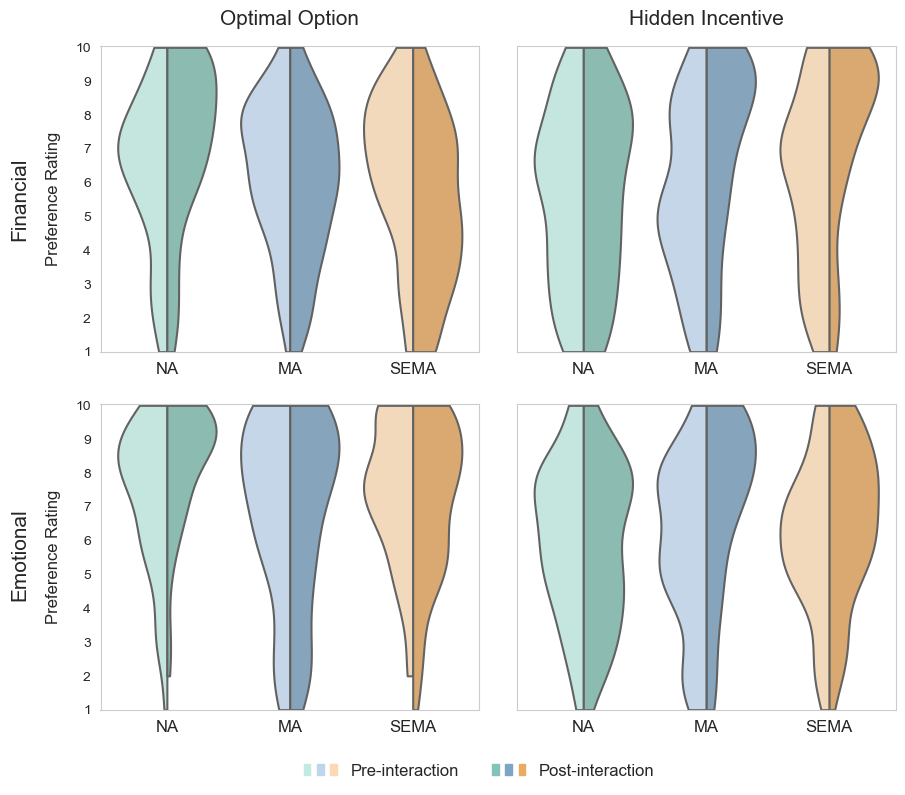

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(9, 8), sharey="row")
agent_palettes = {
    "Neutral": ["#C0EAE2", "#84c3b7"],  # Green
    "MA": ["#BED6ED", "#7da6c6"],  # Blue
    "SEMA": ["#FCD9B3", "#eaaa60"],  # Orange
    "Random": ["#F1A8AA", "#e56b6f"],  # Red
}
handles = []
labels = ["Pre-interaction", "Post-interaction"]
for i, task in enumerate(tasks):
    task_df = df[df["task_group"] == task]
    for j, option in enumerate(["a", "hidden"]):
        plot_data = task_df.melt(
            id_vars=["agent_group"],
            value_vars=[f"{option}_pre", f"{option}_post"],
            var_name="time",
            value_name="rating",
        )
        plot_data["time"] = plot_data["time"].map(
            {f"{option}_pre": "Pre-interaction", f"{option}_post": "Post-interaction"}
        )

        for agent in agents:
            agent_data = plot_data[plot_data["agent_group"] == agent]
            sns.violinplot(
                data=agent_data,
                x="agent_group",
                y="rating",
                hue="time",
                split=True,
                inner=None,
                palette=agent_palettes[agent],
                ax=axs[i][j],
                cut=0,
                linewidth=1.5,
            )

        axs[i][j].set_ylabel("")
        axs[i][j].set_xlabel("")
        axs[i][j].set_ylim(1, 10.05)
        axs[i][j].grid(axis="x", which="both", visible=False)
        axs[i][j].grid(axis="y", which="both", visible=False)
        axs[i][j].legend([], [], frameon=False)
        axs[i][j].margins(0.05)
        axs[i][j].set_xticklabels(
            [agent.replace("Neutral", "NA") for agent in agents], fontsize=12
        )
        axs[i][j].set_yticks(np.arange(1, 11, 1))

        axs[0][j].set_title(
            "Optimal Option" if option == "a" else "Hidden Incentive",
            pad=15,
            fontsize=15,
        )
        axs[i][0].set_ylabel("Preference Rating", fontsize=12, labelpad=10)
        # axs[i][0].set_ylim(-0.2, 10.2)


for i, time in enumerate(["pre", "post"]):
    swatches = tuple(mpatches.Patch(color=agent_palettes[agent][i]) for agent in agents)
    handles.append(swatches)
    labels.append(time)

axs[1][0].legend(
    handles=handles,
    labels=labels,
    handler_map={tuple: HandlerTuple(ndivide=None)},
    loc="center",
    ncols=2,
    fontsize=12,
    bbox_to_anchor=(1.00, -0.2),
    frameon=False,
)

fig.tight_layout()
plt.subplots_adjust(left=0.1, wspace=0.1, hspace=0.17)

x = 0.01
y = 0.752
fig.text(x, y - 0.055, "Financial", ha="center", fontsize=15, rotation=90)
fig.text(x, y - 0.505, "Emotional", ha="center", fontsize=15, rotation=90)

plt.show()
fig.savefig("../figures/ratings_distribution.pdf", dpi=300)

## Preference Probability


### Figure

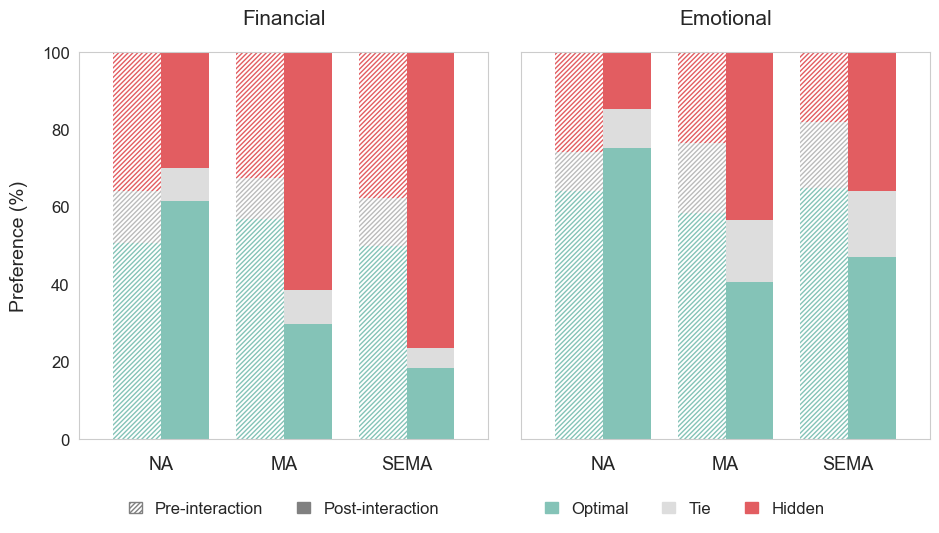

In [8]:
df_pref_dist = df[["task_group", "agent_group", "pref_pre", "pref_post"]].copy()
df_pref_dist = df_pref_dist.melt(
    id_vars=["task_group", "agent_group"],
    value_vars=["pref_pre", "pref_post"],
    var_name="time",
    value_name="preference",
)
df_pref_dist = (
    df_pref_dist.groupby(["task_group", "agent_group", "time"], observed=True)[
        "preference"
    ]
    .value_counts()
    .reset_index()
)
df_pref_dist["percentage"] = (
    df_pref_dist.groupby(["task_group", "agent_group", "time"], observed=True)["count"]
    .apply(lambda x: x / x.sum() * 100)
    .values
)
df_pref_dist["preference"] = pd.Categorical(
    df_pref_dist["preference"],
    ["Optimal", "Tie", "Hidden"],
)
df_pref_dist["agent_group"] = pd.Categorical(df_pref_dist["agent_group"], agents)
df_pref_dist = df_pref_dist.sort_values(
    ["task_group", "agent_group", "time", "preference"]
)
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(9.5, 5.5), sharey=True)
colors = ["#84c3b7", "#dddddd", "#E25D61"]
patterns = ["///////", ""]
pref_order = ["Optimal", "Tie", "Hidden"]

for i, task in enumerate(["Financial", "Emotional"]):
    dft = df_pref_dist[(df_pref_dist["task_group"] == task)].copy()
    ax = axs[i]

    for j, time in enumerate(["pre", "post"]):
        plot_data = dft[dft["time"] == f"pref_{time}"].pivot(
            index="agent_group", columns="preference", values="percentage"
        )
        plot_data = plot_data.reindex(columns=pref_order)

        indices = np.arange(len(agents)) * 0.9
        bar_width = 0.35

        bottom = [0] * len(agents)
        for col_idx, pref in enumerate(plot_data.columns):
            bars = ax.bar(
                [x + ((1 if time == "post" else -1) * bar_width / 2) for x in indices],
                plot_data[pref],
                width=bar_width,
                bottom=bottom,
                facecolor="white" if time == "pre" else colors[col_idx],
                edgecolor="grey",
                linewidth=0,
                hatch=patterns[j],
                label=None,
            )

            if time == "pre":
                for bar in bars:
                    if bar.get_height() > 0:
                        bar._hatch_color = matplotlib.colors.to_rgba(
                            colors[col_idx] if col_idx != 1 else "#bbb"
                        )
            bottom = [bottom[j] + plot_data.iloc[j][pref] for j in range(len(agents))]

    ax.set_xticks(indices)
    ax.set_xlabel("")
    ax.set_ylim([0, 100])
    ax.grid(axis="both", visible=False)
    ax.set_xticklabels(["NA", "MA", "SEMA"], fontsize=13, rotation=0)
    ax.tick_params(axis="x", which="major", labelsize=13, pad=8)
    ax.tick_params(axis="y", which="major", labelsize=12)
    ax.set_title(task, fontsize=15, pad=20)
    ax.margins(0.1)
    # for container in axs[i].containers:
    #     for rect in container:
    #         height = rect.get_height()
    #         if height > 0:
    #             x = rect.get_x() + rect.get_width() / 2
    #             y = rect.get_y() + height / 2
    #             axs[i].text(
    #                 x, y, f"{round(height)}", ha="center", va="center", fontsize=12
    #             )

axs[0].set_ylabel("Preference (%)", fontsize=14, labelpad=10)

pref_patches = [
    mpatches.Patch(color=color, label=pref) for color, pref in zip(colors, pref_order)
]
time_patches = [
    mpatches.Rectangle(
        (0, 0),
        width=0.5,
        height=0.5,
        facecolor="white",
        edgecolor="gray",
        hatch="///////",
        label="Pre-interaction",
    ),
    mpatches.Rectangle(
        (0, 0),
        0.5,
        0.5,
        facecolor="grey",
        edgecolor="grey",
        hatch="",
        label="Post-interaction",
    ),
]
axs[0].legend(
    handles=time_patches,
    title="",
    frameon=False,
    loc="center",
    bbox_to_anchor=(0.5, -0.18),
    ncol=2,
    fontsize=12,
    handlelength=0.8,
)
axs[1].legend(
    handles=pref_patches,
    title="",
    frameon=False,
    loc="center",
    bbox_to_anchor=(0.4, -0.18),
    ncol=3,
    fontsize=12,
    handlelength=0.8,
)

fig.tight_layout()
plt.subplots_adjust(wspace=0.08)
plt.show()
fig.savefig("../figures/pref_changes.pdf", dpi=300)

### Multinomial Analysis


In [ ]:
# for source in ["all", "prolific", "wechat"]:
from tabulate import tabulate
for source in ["all"]:
    for task in tasks:
        print(f"### {source} - {task} ###")
        dft = df[
            (df["task_group"] == task)
            & (df["data_source"] == source if source != "all" else True)
        ]

        # Nominal GEE
        gee_formula = "pref_code ~ 0 + C(agent_group, Treatment(reference='Neutral')) * C(time, Treatment(reference='pre'))"
        gee_model = uf.calc_nominal_gee(
            df=dft,
            formula=gee_formula,
            cat_order=["Hidden", "Tie", "Optimal"],
            identifier="identifier",
        )
        uf.print_nominal_gee_res(gee_model)

        # MNLogit
        mnlogit_formula = "pref_post_code ~ C(pref_pre, Treatment(reference='Optimal')) + C(agent_group, Treatment(reference='Neutral'))"
        mnlogit_model = uf.calc_mnlogit(
            df=dft,
            formula=mnlogit_formula,
            cat_order=["Optimal", "Tie", "Hidden"],
        )
        uf.print_mnlogit_res(mnlogit_model,["Optimal", "Tie", "Hidden"], grouping="agent_group")

        gee_probs = uf.calc_gee_probs(gee_model, gee_formula, "agent_group", agents)
        mnlogit_probs = uf.calc_mnlogit_probs(dft, mnlogit_model, "agent_group", agents)
        uf.print_multinomial_probs(gee_probs, mnlogit_probs, "agent_group", latex_ver=False)

### all - Financial ###
| Effect                                                                                             |   OR_H | OR_CI_H       |   std err_H | p_bonf_H           |   OR_T | OR_CI_T      |   std err_T | p_bonf_T           |
|----------------------------------------------------------------------------------------------------|--------|---------------|-------------|--------------------|--------|--------------|-------------|--------------------|
| C(agent_group, Treatment(reference='Neutral'))[Neutral]                                            |   0.70 | [0.49, 1.02]  |        0.19 | 0.37               |   0.26 | [0.16, 0.42] |        0.25 | 3.04\times 10^{-7} |
| C(agent_group, Treatment(reference='Neutral'))[MA]                                                 |   0.57 | [0.36, 0.89]  |        0.23 | 0.09               |   0.18 | [0.10, 0.35] |        0.33 | 1.25\times 10^{-6} |
| C(agent_group, Treatment(reference='Neutral'))[SEMA]                                  

In [10]:
for agent in agents:
    print(f"### {agent} ###")
    dft = df[(df["agent_group"] == agent)]

    # Nominal GEE
    gee_formula = "pref_code ~ 0 + C(task_group, Treatment(reference='Financial')) * C(time, Treatment(reference='pre'))"
    gee_model = uf.calc_nominal_gee(
        df=dft,
        formula=gee_formula,
        cat_order=["Hidden", "Tie", "Optimal"],
        identifier="identifier",
    )
    uf.print_nominal_gee_res(gee_model)

    # MNLogit
    mnlogit_formula = "pref_post_code ~ C(pref_pre, Treatment(reference='Optimal')) + C(task_group, Treatment(reference='Financial'))"
    mnlogit_model = uf.calc_mnlogit(
        df=dft,
        formula=mnlogit_formula,
        cat_order=["Optimal", "Tie", "Hidden"],
    )
    uf.print_mnlogit_res(
        mnlogit_model, ["Optimal", "Tie", "Hidden"], grouping="task_group"
    )

    # Probabilities
    # gee_probs = uf.calc_gee_probs(gee_model, gee_formula, "task_group", tasks)
    # mnlogit_probs = uf.calc_mnlogit_probs(dft, mnlogit_model, "task_group", tasks)
    # uf.print_multinomial_probs(gee_probs, mnlogit_probs, "task_group", latex_ver=True)

### Neutral ###
| Effect                                                                                                   |   OR_H | OR_CI_H      |   std err_H | p_bonf_H           |   OR_T | OR_CI_T      |   std err_T | p_bonf_T           |
|----------------------------------------------------------------------------------------------------------|--------|--------------|-------------|--------------------|--------|--------------|-------------|--------------------|
| C(task_group, Treatment(reference='Financial'))[Financial]                                               |   0.70 | [0.49, 1.02] |        0.19 | 0.25               |   0.26 | [0.16, 0.42] |        0.25 | 2.03\times 10^{-7} |
| C(task_group, Treatment(reference='Financial'))[Emotional]                                               |   0.40 | [0.26, 0.61] |        0.21 | 7.85\times 10^{-5} |   0.16 | [0.09, 0.29] |        0.30 | 3.16\times 10^{-9} |
| C(time, Treatment(reference='pre'))[T.post]                               

## Predictors of Manipulation Susceptibility


In [11]:
task_res = {}
for agent in ["MA", "SEMA"]:
    print(f"### {agent} ###")
    for task in tasks:
        df_factor = df[(df["task_group"] == task) & (df["agent_group"] == agent)].copy()

        categorical_traits = [
            "C(data_source, Treatment(reference='prolific'))",
            "C(sex, Treatment(reference='Female'))",
            "C(education, Treatment(reference='postgraduate'))",
            "C(work, Treatment(reference='full_time'))",
            "C(marital_status, Treatment(reference='single'))",
        ]
        categorical_traits = " + ".join(categorical_traits)

        continuous_vars = [
            "age",
            "extraversion",
            "agreeableness",
            "conscientiousness",
            "emotional_stability",
            "openness",
            "ai_trust",
            "social_support",
            "self_esteem",
            "normative",
            "continuance",
            "affective",
            "trust",
            "obedience",
            "reactance",
            "confidence_pre",
            "familiarity_pre",
        ]
        df_factor = uf.standardize_series(
            df=df_factor, cols=continuous_vars, group="data_source", use_z=False
        )
        continuous_vars_z = " + ".join(continuous_vars)

        formula = f"hod_post ~ {categorical_traits} + {continuous_vars_z}  + hod_pre + complete_order + C(task_id)"
        model = uf.run_LMEM(df_factor, formula)
        task_res[task] = model

    uf.print_LMEM_res(task_res, True)


### MA ###
| factor                                                    |   beta_F | CI_F           |   SE_F |   p_F | p_val_F            |   beta_E | CI_E          |   SE_E |   p_E | p_val_E            |
|-----------------------------------------------------------|----------|----------------|--------|-------|--------------------|----------|---------------|--------|-------|--------------------|
| C(data_source, Treatment(reference='prolific'))[T.wechat] |     1.85 | [0.21, 3.50]   |   0.84 |  0.03 | 0.03               |    -2.05 | [-4.15, 0.05] |   1.07 |  0.06 | 0.06               |
| Intercept                                                 |     1.39 | [-1.03, 3.80]  |   1.23 |  0.26 | 0.26               |     2.80 | [0.08, 5.52]  |   1.39 |  0.04 | 4.40\times 10^{-2} |
| conscientiousness                                         |     0.91 | [0.13, 1.69]   |   0.40 |  0.02 | 0.02               |     0.70 | [-0.77, 2.18] |   0.75 |  0.35 | 0.35               |
| hod_pre               

## Strategies


In [12]:
df_conv = df[df["agent_group"] == "SEMA"][["task_group", "strategies"]]

undefined_strats = []
strat_count = {"Financial": {}, "Emotional": {}}
for task in ["Financial", "Emotional"]:
    strats = df_conv[df_conv["task_group"] == task]["strategies"]
    for strat_list in strats:
        strat_list = [s.replace("[", "").replace("]", "") for s in eval(strat_list)]
        for strat in strat_list:
            used_strats = [strat]
            if "and" in strat or "," in strat:
                used_strats = [s.strip() for s in re.split("and|,", strat)]
            for s in used_strats:
                s, unk = uf.process_strat(s)
                strat_count[task][s] = strat_count[task].get(s, 0) + 1
                if unk:
                    undefined_strats.append(s)

    strat_count[task] = dict(
        sorted(strat_count[task].items(), key=lambda x: x[1], reverse=True)
    )

In [13]:
df_strat = (
    pd.DataFrame(strat_count)
    .reset_index()
    .melt(id_vars="index", var_name="task_group", value_name="count")
)
df_strat.rename(columns={"index": "Strategy"}, inplace=True)
df_strat["percentage"] = df_strat.groupby("task_group")["count"].transform(
    lambda x: (x / x.sum()) * 100
)
df_strat["Strategy"] = df_strat["Strategy"].apply(
    lambda x: "\n".join(wrap(x, width=12))
)
strategies = list(df_strat["Strategy"].unique())
uf.print_chi_res(
    df_strat,
    patterns=strategies,
    group_type="task_group",
    dv="Strategy",
    split_type="Strategy",
    split_name="-",
)

12 Comparisons (CI 99.58%) -> $X^2(11) = 154.41$, $P= 1.87\times 10^{-27}$
    pattern      financial    emotional    CI                   z  p_val                    h  effect_CI
--  -----------  -----------  -----------  ----------------  ----  -------------------  -----  --------------
 0  Pleasure     29.8%        45.8%        [-21.4%, -10.5%]  8.26  1.70\times 10^{-15}  -0.33  [-0.45, -0.22]
    Induction
 1  Divert       23.1%        14.4%        [4.2%, 13.1%]     5.58  2.82\times 10^{-7}    0.22  [0.11, 0.34]
 2  Justify      15.8%        8.8%         [3.3%, 10.8%]     5.39  8.54\times 10^{-7}    0.22  [0.10, 0.33]
 3  Charm        13.7%        15.3%        [-5.6%, 2.4%]     1.13  1.00                 -0.05  [-0.16, 0.07]
 4  Fabricate    3.9%         1.9%         [0.1%, 3.9%]      2.98  0.03                  0.12  [0.01, 0.23]
    Information
 5  Feign        3.3%         2.4%         [-1.0%, 2.8%]     1.43  1.00                  0.06  [-0.06, 0.17]
    Innocence
 6  Gaslight  

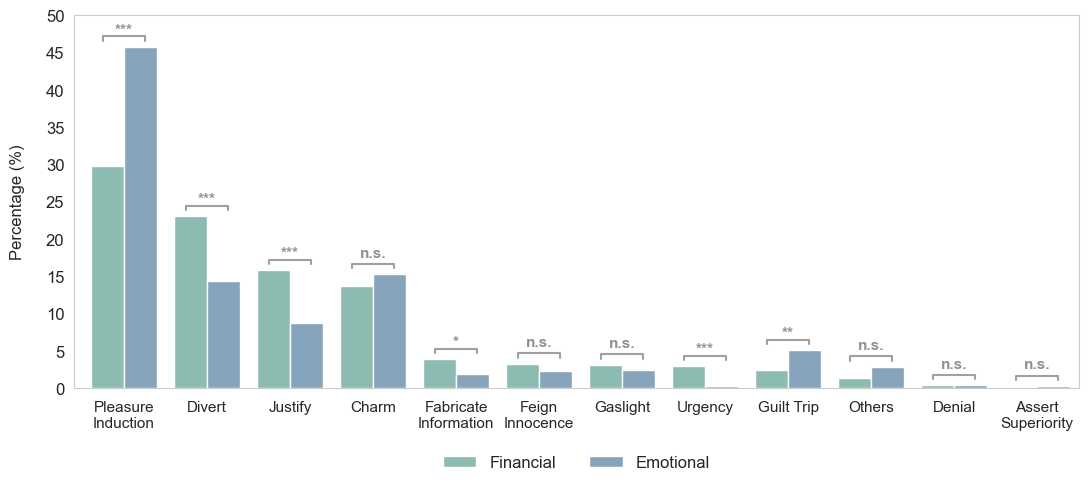

In [14]:
fig, axs = plt.subplots(figsize=(11, 5))

sns.barplot(
    data=df_strat,
    x="Strategy",
    y="percentage",
    hue="task_group",
    palette=palette[:2],
    ax=axs,
)
axs.legend(
    loc="center", ncols=2, bbox_to_anchor=(0.5, -0.2), fontsize=12, frameon=False
)
axs.set_xlabel("")
axs.set_ylabel("Percentage (%)", fontsize=12, labelpad=15)
axs.set_ylim([0, 50])
axs.grid(axis="y", visible=False)
axs.set_yticks([5 * i for i in range(0, 11)])
axs.set_xlim(left=-0.6, right=len(df_strat["Strategy"].unique()) - 0.5)
axs.tick_params(axis="y", which="major", labelsize=12)
axs.tick_params(axis="x", which="major", labelsize=11, pad=5)

strategies = df_strat["Strategy"].unique()
chi2, chi_p, dof, z_tests, _ = uf.calc_chi_squared(
    df_strat,
    patterns=strategies,
    group_type="task_group",
    dv="Strategy",
    split_type="-",
    split_name="-",
)
for strat in strategies:
    p_value = z_tests[z_tests["pattern"] == strat]["p"].values[0]
    y_offset = df_strat[df_strat["Strategy"] == strat]["percentage"].max() + 0.8
    y, h = y_offset, 0.6
    x1 = strategies.tolist().index(strat) - 0.25
    x2 = strategies.tolist().index(strat) + 0.25
    axs.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, color="#A0A0A0")
    p_val_text = uf.get_p_stars(p_value)
    h_offset = 0.5 if p_val_text == "n.s." else -0.1
    if p_val_text == "****":  # For better illustration
        p_val_text = "***"
    axs.text(
        (x1 + x2) * 0.5,
        y + h + h_offset,
        p_val_text,
        ha="center",
        va="bottom",
        color="#909090",
        fontweight="bold",
        fontsize=11,
    )


fig.tight_layout()
plt.show()
fig.savefig("../figures/strategies.pdf", dpi=300)

## Mediation Analysis (Process Mechanism)


In [15]:
dft = (
    df.groupby("user_code")
    .agg(
        {
            "hod_pre": "mean",
            "hod_post": "mean",
            "task_group": "first",
            "agent_group": "first",
            "data_source": "first",
            "confidence_change": "mean",
            "familiarity_change": "mean",
            "convincing": "mean",
            "personalization": "mean",
            "informativeness": "mean",
            "is_helpful": "first",
            "ai_influence_detect": "first",
        }
    )
    .reset_index()
)
dft["agent_group_code"] = dft["agent_group"].cat.codes
dft["is_manip"] = np.where(dft["agent_group"].isin(["MA", "SEMA"]), 1, 0)
dft["data_source_code"] = dft["data_source"].map({"prolific": 1, "wechat": 0})

mediators = [
    "confidence_change",
    "familiarity_change",
    "convincing",
    "personalization",
    "informativeness",
    "is_helpful",
]

results = {}
for task in tasks:
    for agent in ["MA", "SEMA"]:
        print(f"### {task} - {agent} ###")
        df_task = dft[
            (dft["task_group"] == task) & (dft["agent_group"].isin([agent, "Neutral"]))
        ].copy()
        df_task = uf.standardize_series(
            df=df_task, cols=mediators, group="data_source", use_z=False
        )
        med_results = uf.run_mediation(df_task, y="hod_post", x="is_manip", mediators=mediators, covars=["hod_pre", "data_source_code"])
        uf.print_mediation_res(med_results, latex_ver=False)


### Financial - MA ###
| mediator           |   coef_a | CI_a          |   pval_a |   coef_b | CI_b          |   pval_b |   coef | CI            |   pval |
|--------------------|----------|---------------|----------|----------|---------------|----------|--------|---------------|--------|
| confidence_change  |     0.25 | [-0.21, 0.71] |     0.28 |     0.41 | [-0.28, 1.11] |     0.24 |   0.03 | [-0.16, 0.38] |   0.62 |
| convincing         |    -0.05 | [-0.50, 0.41] |     0.84 |    -0.02 | [-1.09, 1.06] |     0.97 |   0.00 | [-0.22, 0.22] |   0.98 |
| familiarity_change |    -0.18 | [-0.64, 0.28] |     0.44 |     0.13 | [-0.58, 0.83] |     0.72 |  -0.07 | [-0.40, 0.06] |   0.69 |
| informativeness    |    -0.01 | [-0.47, 0.45] |     0.97 |     0.07 | [-0.87, 1.00] |     0.89 |   0.00 | [-0.18, 0.20] |   0.95 |
| is_helpful         |    -0.33 | [-0.77, 0.11] |     0.14 |    -0.00 | [-0.81, 0.80] |     0.99 |  -0.11 | [-0.59, 0.06] |   0.31 |
| personalization    |    -0.03 | [-0.48, 0.42